In [4]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from datetime import timedelta
import os
import math
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler
from pytrends.request import TrendReq
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
import warnings


In [5]:
#Dictionary for state and abbreviation conversion
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [6]:
# Create dictionary for FIPS code
url = 'https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-locations/locations.csv'
df_fips = pd.read_csv(url, error_bad_lines=False)
us_state_fips = {}
for index, row in df_fips.iterrows():
    if index < 58 and index >= 0:
        us_state_fips[row["location_name"]] = row["location"]
us_state_fips

{'US': 'US',
 'Alabama': '01',
 'Alaska': '02',
 'Arizona': '04',
 'Arkansas': '05',
 'California': '06',
 'Colorado': '08',
 'Connecticut': '09',
 'Delaware': '10',
 'District of Columbia': '11',
 'Florida': '12',
 'Georgia': '13',
 'Hawaii': '15',
 'Idaho': '16',
 'Illinois': '17',
 'Indiana': '18',
 'Iowa': '19',
 'Kansas': '20',
 'Kentucky': '21',
 'Louisiana': '22',
 'Maine': '23',
 'Maryland': '24',
 'Massachusetts': '25',
 'Michigan': '26',
 'Minnesota': '27',
 'Mississippi': '28',
 'Missouri': '29',
 'Montana': '30',
 'Nebraska': '31',
 'Nevada': '32',
 'New Hampshire': '33',
 'New Jersey': '34',
 'New Mexico': '35',
 'New York': '36',
 'North Carolina': '37',
 'North Dakota': '38',
 'Ohio': '39',
 'Oklahoma': '40',
 'Oregon': '41',
 'Pennsylvania': '42',
 'Rhode Island': '44',
 'South Carolina': '45',
 'South Dakota': '46',
 'Tennessee': '47',
 'Texas': '48',
 'Utah': '49',
 'Vermont': '50',
 'Virginia': '51',
 'Washington': '53',
 'West Virginia': '54',
 'Wisconsin': '55',
 '

In [7]:
kw_list = ["covid treatment",
            "treatment for covid",
            "treat covid",
            "covid in old",
            "covid fever",
            "covid vaccine",
            "covid in adults",
            "covid testing",
            "what to do if you have covid",
            "coronavirus",
            "ICU",
            "covid death rate",
            "stimulus package",
            "how long does covid last",
            "thermoscan",
            "covid incubation period",
            "covid",
            "covid symptoms",
            "how long is covid contagious",
            "fever and cough",
            "covid pneumonia",
            "quarantine",
            "unemployment rate",
            "covid recovery time",
            "covid cdc",
            "cdc suggestion",
            "covid side effects",
            "how contagious is covid",
            "signs of covid",
            "covid cases",
            "vaccine",
            "how to get rid of covid",
            "covid in children",
            "how to treat covid",
            "covid infection rate",
            "reopen",
            "covid report",
            "do I have covid",
            "mask",
            "social distancing",
            "zoom",
            "work from home",
            "how bad is covid in",
            "Anthony Fauci",
            "ventilator",
            "travel ban",
            "black lives matter",
            "protests",
            "loot",
            "Tik Tok ban",
            "symptons of covid",
            "covid duration",
            "covid contagious",
            "treat covid",
            "how to treat covid",
            "covid or cold",
            "covid medicine",
            "normal body",
            "is covid contagious",
            "body temperature",
            "is covid contagious",
            "testing covid",
            "covid vs cold",
            "get over covid",
            "dangerous fever",
           "second outbreak",
           "covid outbreak",
           "lockdown",
           "online classes",
           "college basketball",
           "college football"
            ]
len(kw_list)

71

In [8]:
#get data from Google trends
def get_data(geo='US'):
    if geo == "US":
        state = "US"
    else:
        state = "US-" + us_state_abbrev[geo]
    pytrends = TrendReq(hl='en-US', tz=360)
    

    pytrends.build_payload([kw_list[0]], cat=0, timeframe='2020-01-01 2020-08-11', geo=state, gprop='')
    df1 = pytrends.interest_over_time()
    df = pd.DataFrame(index = df1.index)    
    df[df1.columns[0]] = df1.iloc[:,0]

    for keyword in kw_list[1:]:
        pytrends.build_payload([keyword], cat=0, timeframe='2020-01-01 2020-08-11', geo=state, gprop='')
        df1 = pytrends.interest_over_time()
        try:
            df[df1.columns[0]] = df1.iloc[:,0]
        except:
            df[keyword] = 0
            print(keyword + " does not exist.")

    df.replace("<1",0.5,inplace=True)
    outdir = './Data/' + geo
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    df.to_csv("./Data/" + geo + "/" + geo + "_gt.csv")
    
    #log-transformation
    df_log = pd.DataFrame(index = df.index)
    for column in df.columns:
        df_log[column] = np.log(df[column]+0.5)
    df_log.to_csv("./Data/merged/" + geo + "_merged.csv")


In [9]:
def read_ground_truth(state):
    df_c = pd.read_csv("../Ground Truth/cum_case.csv",index_col="Province_State")
    df_d = pd.read_csv("../Ground Truth/cum_death.csv",index_col="Province_State")
    df_ic = pd.read_csv("../Ground Truth/inc_case.csv",index_col="Province_State")
    df_id = pd.read_csv("../Ground Truth/inc_death.csv",index_col="Province_State")
    
    df = pd.DataFrame(columns=df_c.columns)
    df = df.append(df_c.loc[state],ignore_index=False)
    df.rename({state:"Confirmed"},inplace=True)
    df = df.append(df_d.loc[state],ignore_index=False)
    df.rename({state:"Deaths"},inplace=True)
    df = df.append(df_ic.loc[state],ignore_index=False)
    df.rename({state:"New_Confirmed"},inplace=True)
    df = df.append(df_id.loc[state],ignore_index=False)
    df.rename({state:"New_Deaths"},inplace=True)
    df.drop(["2020-03-01"],axis=1,inplace=True)
    
    df_gt = pd.read_csv("./Data/merged/" + state + "_merged.csv", index_col = "date")
    
    return df.T,df_gt
    
    

In [14]:
#p is the order of AR model; N is the information lag
def ARGOnet(state,category,p,N,df_coef,pred):
    df,df_gt = read_ground_truth(state)
    df_temp = pd.DataFrame(df[category],index=df.index)
    df_temp_gt = df_gt.copy()
    
    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp[category].shift(i)
    
    for keyword in df_gt.columns:
        for i in range(1,N+1):
            df_temp_gt['Shifted_' + keyword + '_%d' %  i] = df_temp_gt[keyword].shift(i)

    df = pd.concat([df_temp,df_temp_gt],axis=1,join="inner") 
    
    columns = []
    for column in df_temp.columns[1:]:
        columns.append(column)
    for column in df_temp_gt.columns[len(df_gt.columns):]:
        columns.append(column)
    
    if df_coef.empty:
        df_coef = pd.DataFrame(columns=columns)
    
    train_size = (int)(0.8 * df.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df[0:train_size]).dropna()
    df_test = pd.DataFrame(df[train_size:df.shape[0]])

    X_train = df_train.iloc[:,len(df_gt.columns) + 1:].values.reshape(-1,p+N*len(df_gt.columns))
    y_train = df_train.iloc[:,0].values.reshape(-1,1)

    best_alpha = cv_alpha(X_train,y_train)
    print("best alpha: ", best_alpha)
    
    
    clf = Lasso(alpha=best_alpha)
    clf.fit(X_train,y_train)

    theta  = clf.coef_.T
    df_coef.loc[state+"_"+category] = theta
    
    outdir = './Plots/' + state
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    intercept = clf.intercept_
    df_train['Predicted_Values'] = X_train.dot(theta) + intercept
    ax = df_train[[category,'Predicted_Values']].plot()
    plt.gcf().autofmt_xdate()
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.title(state + ' ' + category + "_train")
    plt.savefig("./Plots/" + state + '/' + state + "_" + category + "_train.png")
    plt.show()
    
    X_test = df_test.iloc[:,len(df_gt.columns) + 1:].values.reshape(-1,p+N*len(df_gt.columns))
    Y_test = df_test.iloc[:,0].values.reshape(-1,1)
    df_test['Predicted_Values'] = X_test.dot(theta) + intercept
    df_test['Predicted_Values'][df_test['Predicted_Values'] < 0] = 0

    ax = df_test[[category,'Predicted_Values']].plot()
    plt.gcf().autofmt_xdate()
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.title(state + ' ' + category)
    plt.savefig("./Plots/" + state + '/' + state + "_" + category + ".png")
    plt.show()

    RMSE = np.sqrt(mean_squared_error(Y_test, df_test['Predicted_Values']))
    print("The RMSE is :", RMSE,", Value of p : ",p,", Value of N : ",N)
    
    df_new = pd.DataFrame(columns=["location", "target","type","quantile","forecast_date","target_end_date","value"])
    df_new["target_end_date"] = df_test.index
    test_date = [datetime.strptime(d, '%Y-%m-%d').date() for d in df_test.index]
    forecast_date = [d-timedelta(days=1) for d in test_date]
    df_new["forecast_date"] = forecast_date
    df_new["target_end_date"] = test_date
    df_new["location"] = us_state_fips[state]
    if category == "New_Deaths":
        df_new["target"] = "1 day ahead inc death"
    else:
        df_new["target"] = "1 day ahead inc case"
    df_new["type"] = "point"
    df_new["quantile"] = "NA"
    df_new["value"] = df_test["Predicted_Values"].values
    
    if pred.empty:
        pred = df_new
    else:
        pred = pd.concat([pred,df_new],axis=0,ignore_index=True)
    
    return [pred,df_coef]        
     

In [15]:
def cv_alpha(X,y):
    alphas = np.logspace(-1000, 1, 1000)
    best_alpha = None
    best_MSE = float('inf')
    for alpha in alphas:
        warnings.filterwarnings("ignore")
        clf = Lasso(alpha=alpha)
        cv_results = cross_validate(clf, X, y, cv=5, scoring="neg_mean_squared_error")
        mean = -cv_results["test_score"].mean()
        if mean < best_MSE:
            best_MSE = mean
            best_alpha = alpha
    
    return best_alpha

In [16]:
pred = pd.DataFrame(columns=["location", "target","type","quantile","forecast_date","target_end_date","value"])
df_coef = pd.DataFrame()

best alpha:  10.0


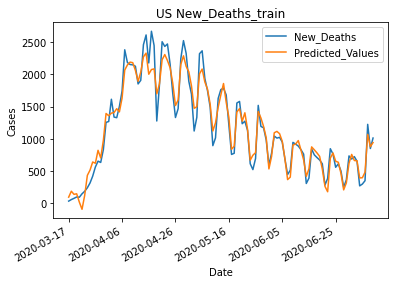

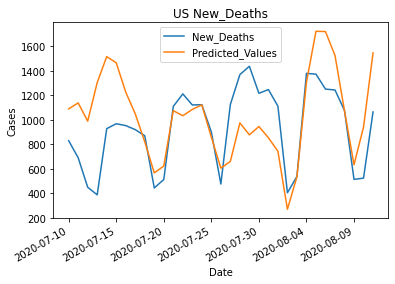

The RMSE is : 350.7517075518251 , Value of p :  15 , Value of N :  6
best alpha:  0.9954008287619585


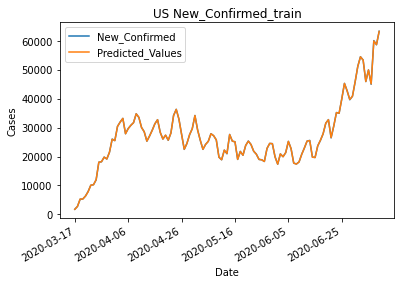

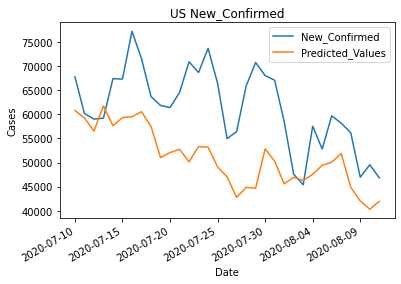

The RMSE is : 12297.652093287079 , Value of p :  15 , Value of N :  6
best alpha:  10.0


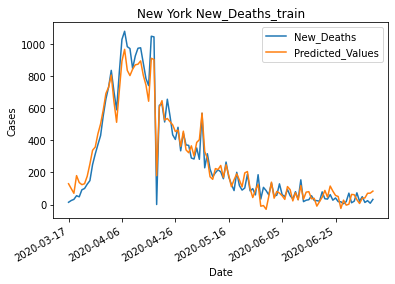

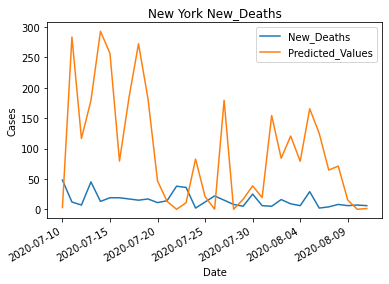

The RMSE is : 121.745104997286 , Value of p :  15 , Value of N :  6
best alpha:  0.9954008287619585


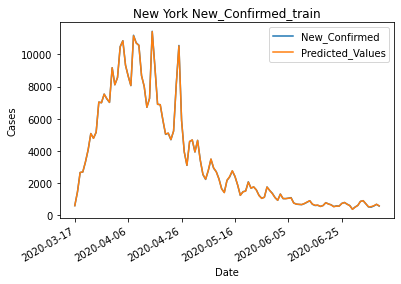

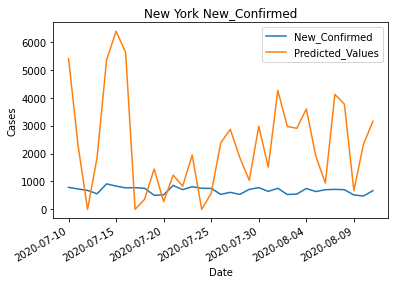

The RMSE is : 2362.188778333149 , Value of p :  15 , Value of N :  6
best alpha:  10.0


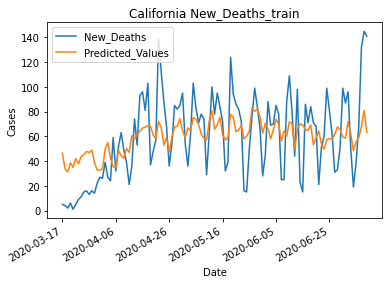

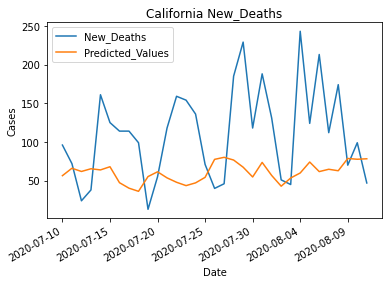

The RMSE is : 79.22761316536332 , Value of p :  15 , Value of N :  6
best alpha:  0.0990822809900253


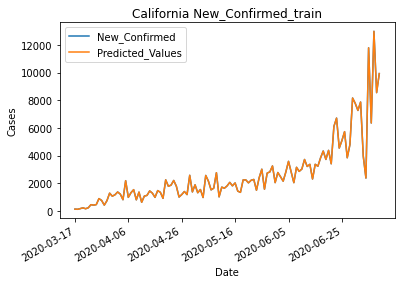

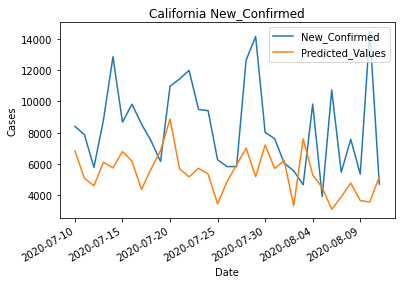

The RMSE is : 4162.638400855641 , Value of p :  15 , Value of N :  6
best alpha:  8.588828559545029e-33


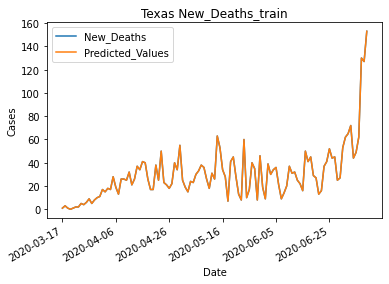

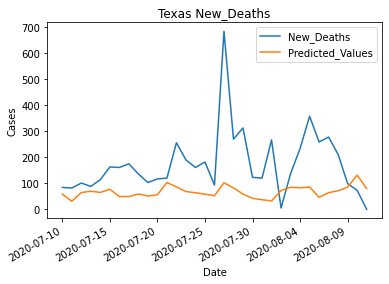

The RMSE is : 161.37885939658 , Value of p :  15 , Value of N :  6
best alpha:  0.0


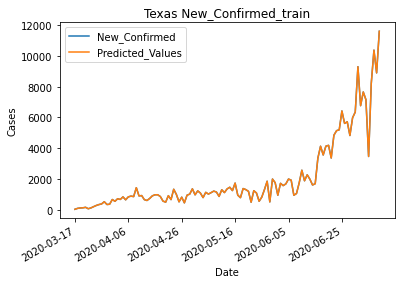

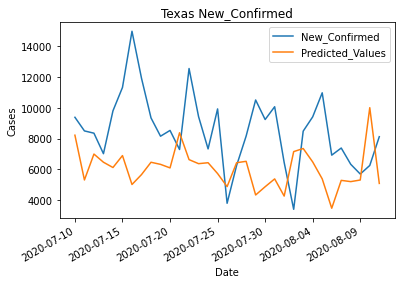

The RMSE is : 3691.744339744414 , Value of p :  15 , Value of N :  6
best alpha:  10.0


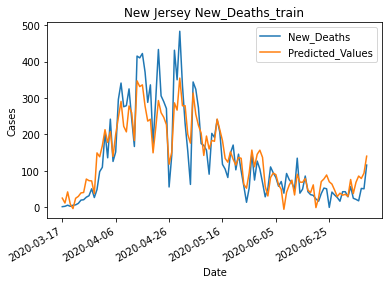

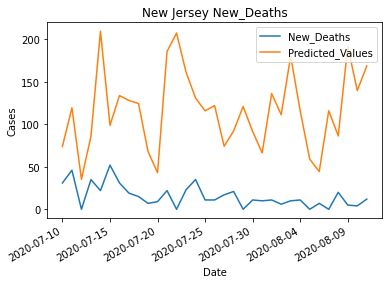

The RMSE is : 111.41532717551104 , Value of p :  15 , Value of N :  6
best alpha:  10.0


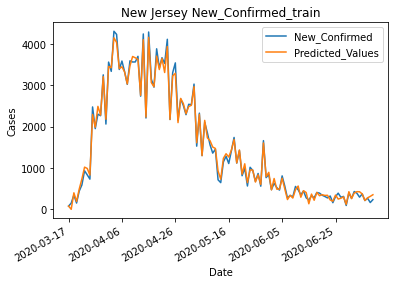

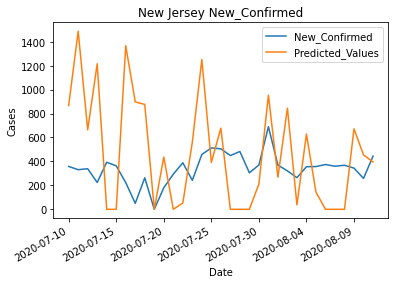

The RMSE is : 493.8119398687209 , Value of p :  15 , Value of N :  6
best alpha:  0.9954008287619585


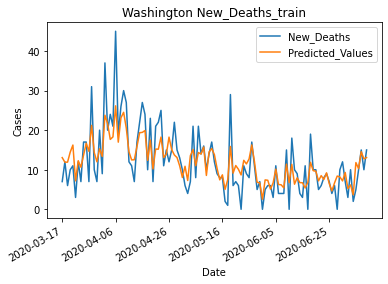

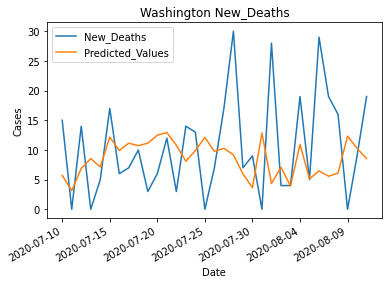

The RMSE is : 9.543318139465415 , Value of p :  15 , Value of N :  6
best alpha:  0.0990822809900253


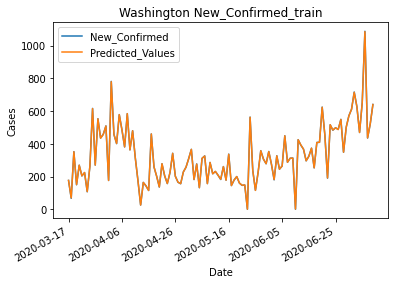

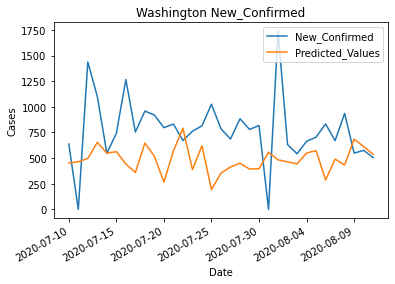

The RMSE is : 461.93303613525177 , Value of p :  15 , Value of N :  6
best alpha:  10.0


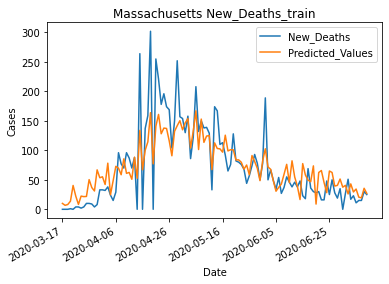

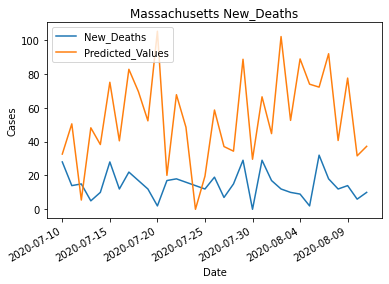

The RMSE is : 47.34788098006054 , Value of p :  15 , Value of N :  6
best alpha:  10.0


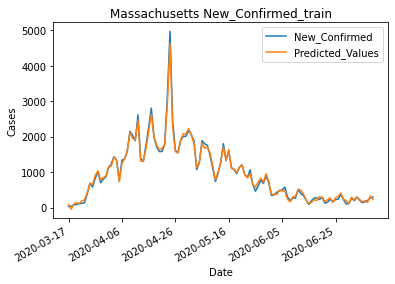

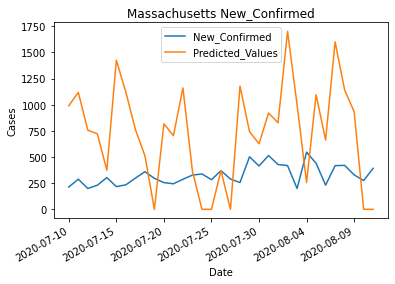

The RMSE is : 622.030086975225 , Value of p :  15 , Value of N :  6
best alpha:  10.0


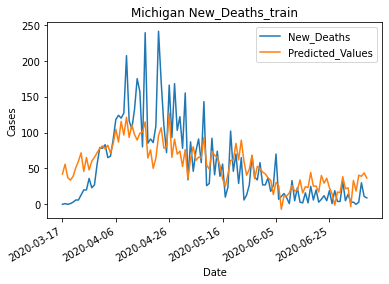

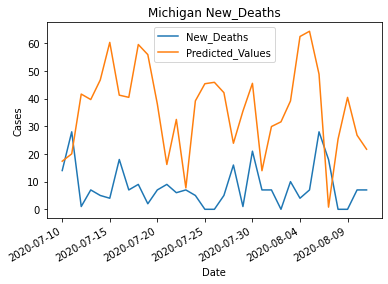

The RMSE is : 33.87120644528021 , Value of p :  15 , Value of N :  6
best alpha:  10.0


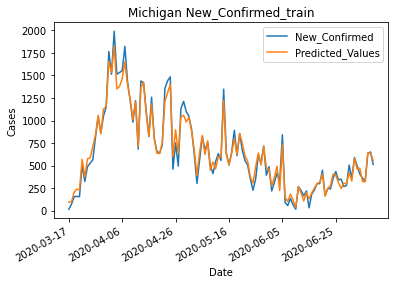

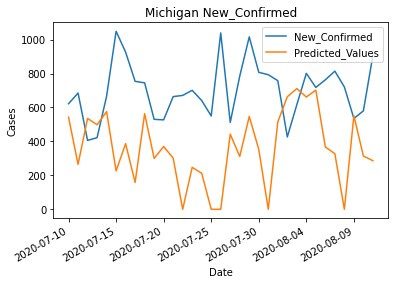

The RMSE is : 453.8776335765487 , Value of p :  15 , Value of N :  6


In [17]:
states = ["US", "New York", "California", "Texas", "New Jersey", "Washington", "Massachusetts", "Michigan"]
for state in states:
    get_data(state)
    [pred,df_coef]=ARGOnet(state,"New_Deaths",15,6,df_coef,pred)    
    [pred,df_coef]=ARGOnet(state,"New_Confirmed",15,6,df_coef,pred)



In [18]:
pred.to_csv("./GITIDEAS-ARGOnet.csv",index=False)
df_coef.to_csv("./coef.csv")